<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-03-tree-based-models-bagging-cforest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.3 Conditional Random Forest (cforest)

Conditional Random Forest (cforest) builds on ensemble learning method that constructs multiple decision trees but uses **conditional inference trees** (implemented via the `ctree` algorithm) instead of standard CART (Classification and Regression Trees). These trees are based on a statistical framework that tests the independence between predictors and the response variable to guide splitting decisions. This notebook will cover the theoretical background, implementation details, and practical applications of cforest with Python.

## Overview

A **Conditional Random Forest (cforest)** is an extension of the Random Forest algorithm that uses **conditional inference trees** as its base learners instead of standard decision trees. It was introduced to address some limitations of traditional Random Forests, particularly in handling variable selection bias and providing more robust statistical inference. The `cforest` algorithm is implemented in the R package `party` and is designed to work within a conditional inference framework, which ensures unbiased variable selection and better handling of complex data structures.

Key Features of cforest:

-   `Unbiased Variable Selection`: Unlike traditional Random Forests, which may favor variables with more categories or continuous variables, cforest uses conditional inference to select variables without bias.

-   `Statistical Rigor`: It incorporates permutation-based significance tests to decide splits, making it more robust for datasets with complex relationships or correlated predictors.

-`Flexibility`: cforest can handle various types of response variables (e.g., continuous, categorical, survival data) and is less sensitive to overfitting in certain scenarios.


### How Does Conditional Random Forest (cforest) Work?

The **Conditional Random Forest (cforest)** algorithm combines the ensemble approach of Random Forests with the **conditional inference framework** to reduce bias in variable selection and handle mixed data types effectively. Below is a detailed explanation, incorporating mathematical formulations where relevant:

1. Input Data

-   `Dataset`: Let $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ be the dataset, where:

  -   $\mathbf{x}_i = (x_{i1}, x_{i2}, \dots, x_{ip})$ is a vector of $p$ predictor variables (numeric or categorical).

  -   $y_i$ is the response variable (continuous for regression, categorical for classification).

-   The goal is to predict $y$ given $\mathbf{x}$ using an ensemble of conditional inference trees.

2. Bootstrapping or Subsampling

-   `Bagging`: For each tree $t = 1, 2, \dots, T$, a bootstrap sample $D_t$ is drawn from $D$ with replacement, typically of size $n$. The probability that a specific observation $(\mathbf{x}_i, y_i)$ is included in $D_t$ is approximately $1 - (1 - 1/n)^n \approx 1 - e^{-1} \approx 0.632$.

-   `Subsampling`: Alternatively, a random subset of size $m< n$ is drawn without replacement. This reduces correlation between trees compared to bagging.

-   `Out-of-Bag (OOB) Sample`: Observations not included in $D_t$ form the OOB sample, used for estimating generalization error.

3.  Building Conditional Inference Trees

Each tree in cforest is a **conditional inference tree** (`ctree`), constructed using a statistical framework to ensure unbiased variable selection. The process involves:

3.1  `Variable Selection via Conditional Inference`:

  -   At each node, cforest tests the null hypothesis $H_0: Y \perp X_j \mid \mathbf{X}_{-j}$ for each predictor $X_j$, where $\mathbf{X}_{-j}$ denotes all other predictors.

    -   The test is based on a `permutation test`:

        -   Compute a test statistic (e.g., for regression, a correlation-based statistic; for classification, a chi-squared or Gini-based statistic).

        -   Permute the values of $X_j$ while keeping $Y$ and $\mathbf{X}_{-j}$ fixed to generate a null distribution.

        -   Calculate the p-value as the proportion of permuted test statistics exceeding the observed statistic:

$$  p_j = P(T(\mathbf{X}_j^{\text{perm}}, Y) \geq T(\mathbf{X}_j, Y) \mid \mathbf{X}_{-j}) $$

        
 - Select the predictor $X_j$ with the smallest p-value, provided $p_j < \alpha$ (e.g., $\alpha = 0.05$).

  - This ensures unbiased variable selection, unlike standard Random Forest, which may favor variables with more split points (e.g., continuous variables).


3.2 `Split Point Selection`:

  -   For the selected predictor $X_j$:

        -   If $X_j$ is continuous, evaluate split points $\in {x_{ij} \mid i \in \text{node}}$.

        -   If $X_j$ is categorical with levels ${c_1, c_2, \dots, c_k}$, consider all possible binary splits (e.g., ${c_1, c_2}$ vs. ${c_3, \dots, c_k}$).

    -   Choose the split that maximizes a test statistic, such as the standardized linear statistic:

$$  T_j(s) = \sum_{i \in \text{node}} w_i (y_i - \bar{y}) (x_{ij} - \bar{x}_j) \cdot I(x_{ij} \leq s) $$

        
 where $w_i $ are weights (typically 1), and $I$ is the indicator function.


-   The split maximizes the separation of $Y$ values in the child nodes.

3.3  `Recursive Partitioning*`

   -   Split the node into two child nodes based on the selected variable and split point.

   -   Recursively apply the above steps to each child node until a stopping criterion is met.

3.4  `topping Criteria`:

  -   Stop splitting if:

       -   No predictor has a p-value $< \alpha$ (no significant association).

        -   The node size is below a threshold (e.g., $n_{\text{min}} = 10$).

        -   A maximum tree depth is reached.

    -   The terminal node assigns a prediction (e.g., mean $y$ for regression, majority class for classification).

4. Ensemble Prediction

-   `Regression`:

   -   For a new observation $\mathbf{x}$, each tree \$t \$ predicts $\hat{y}_t(\mathbf{x})$.

   -   The final prediction is the average across all trees:

$$ \hat{y}(\mathbf{x}) = \frac{1}{T} \sum_{t=1}^T \hat{y}_t(\mathbf{x}) $$

-   `Classification`:

  -   Each tree votes for a class $\hat{y}_t(\mathbf{x})$.
  -   The final prediction is the majority class or averaged class probabilities:

$$  \hat{y}(\mathbf{x}) = \arg\max_c \left( \frac{1}{T} \sum_{t=1}^T I(\hat{y}_t(\mathbf{x}) = c) \right) $$

-   `OOB Error`:

   -   For each observation $(\mathbf{x}_i, y_i)$, use only trees where $(\mathbf{x}_i, y_i) \notin D_t$.

  -   Compute OOB predictions and estimate error (e.g., RMSE for regression, misclassification rate for classification).

5. Variable Importance

-   `Permutation Importance`:

  -   For predictor $X_j$, permute its values in the OOB sample for tree $t$.
  
  -   Compute the increase in OOB error (e.g., MSE for regression):

$$  \text{Importance}(X_j) = \frac{1}{T} \sum_{t=1}^T \left( \text{MSE}_{\text{perm},t} - \text{MSE}_{\text{orig},t} \right) $$

-   Higher values indicate greater importance.


Below is a flowchart illustrating the process of building a Conditional Random Forest (cforest):

![alt text](http://drive.google.com/uc?export=view&id=1nRfrCMuys21NkrUx43xOsJ_mkTSQDNyr)


### Comparison with Standard Random Forest

| **Aspect** | **Random Forest (CART)** | **Conditional Random Forest (cforest)** |
|------------------|---------------------------|---------------------------|
| **Base Learner** | CART (decision trees) | Conditional inference trees (`ctree`) |
| **Variable Selection** | Based on impurity (Gini, MSE) | Based on conditional inference (p-values) |
| **Bias in Splitting** | Biased toward variables with more categories | Unbiased, uses permutation tests |
| **Computational Speed** | Faster | Slower due to statistical tests |
| **Implementation** | Widely available (e.g., scikit-learn, R) | Primarily in R’s `partykit` package |
| **Interpretability** | Less statistically rigorous | More rigorous (p-value-based splits) |

## Conditional Random Forest (cforest) in Python


The *Conditional Random Forest* (often referred to as `cforest`) is a tree-based ensemble method originally developed in R through the `party` package. Unlike traditional Random Forests that use recursive partitioning based on impurity measures (like Gini or variance), **cforest employs conditional inference tests** at each split, making it less biased toward variables with many splits or higher cardinality.

In Python, there is no official `cforest` implementation in mainstream libraries like scikit-learn. However, custom implementations—such as the `CForest` class—aim to mimic the behavior of R’s `party::cforest()` by combining random forests with **unbiased variable selection**, often using statistical tests (e.g., permutation tests) and **subsampled data without bootstrap sampling**.

Key features of a Python `cforest` approach include:
- **Unbiased variable selection**: Splits are chosen using hypothesis tests, reducing selection bias.
- **Permutation importance**: More reliable feature importance measures, avoiding biases in Gini or MSE-based importances.
- **Subsampling**: Typically draws samples without replacement (unlike standard Random Forests).
- **Conditional inference framework**: Potential use of test statistics (`quadratic`, `max`) and correction methods (`Bonferroni`, `Monte Carlo`).

While current Python versions often wrap scikit-learn’s `RandomForest` for convenience, a true `cforest` would implement conditional inference trees (ctree) as base learners. Until then, these hybrid implementations offer a practical step toward **more statistically sound, interpretable random forests** in Python.


### Custom cforest implementation

Below is a Python implementation of a conditional random forest similar to R's `cforest()` function from the {party} package. We are currently using scikit-learn's `RandomForestClassifier` and `RandomForestRegressor` which are based on traditional decision trees (using impurity-based splits). To truly mimic R's `cforest`, we should use "Conditional Inference Trees" as the base learners. However, scikit-learn does not provide an implementation of conditional inference trees.

To work around this limitation, we can use the following strategies:

1. **Custom Tree Implementation**: Create a custom tree class that mimics conditional inference trees using existing scikit-learn components.
2. **Hybrid Approach**: Combine scikit-learn's random forests with statistical tests for variable importance.
3. **Use of Other Libraries**: Explore other libraries like `statsmodels` for statistical tests and integrate them with scikit-learn

The code is necessary for several key reasons, as there's no native Python equivalent to R's comprehensive `cforest` implementation:

 1. **Lack of Native Implementation**
   - **No direct equivalent**: Python lacks a package that fully replicates R's conditional inference framework from the `party` package
   - **Partial alternatives**: Packages like `sklearn` provide random forests but not the conditional inference approach

2. **Core Differences from Standard Random Forests**
   - **Conditional inference trees**: Use statistical tests (p-values) for splits instead of impurity reduction
   - **Unbiased variable selection**: Better handles correlated predictors and high-dimensional data
   - **Statistical foundation**: Based on permutation tests rather than greedy algorithms

3. **Workarounds for Python Limitations**

   - **Tree building**: Uses scikit-learn trees with constraints to approximate conditional inference
   - **Statistical testing**: Approximates through permutation importance rather than direct p-value splits
   - **Memory efficiency**: Handles large datasets through scikit-learn's optimized backend

Key Differences from Standard Random Forests

| Feature                | Standard RF (sklearn)   | This CForest          |
|------------------------|-------------------------|-----------------------|
| **Split criterion**    | Gini/Impurity           | Statistical tests    |
| **Variable selection** | Biased with correlations | Unbiased            |
| **Subsampling**        | Bootstrap (with repl)   | 63.2% without repl  |
| **Importance**         | Mean Decrease Impurity  | Permutation-based   |
| **Statistical basis**  | Heuristic               | Hypothesis testing  |

### When to Use This Implementation
1. **Need for unbiased variable selection**: When predictors are highly correlated
2. **High-dimensional data**: Better handles features > observations
3. **Interpretable importance**: Permutation importance > Gini importance
4. **Statistical rigor**: When hypothesis testing framework is preferred
5. **R parity**: When migrating R workflows to Python

This implementation provides the most Pythonic approximation of R's `cforest` while maintaining computational efficiency and scikit-learn compatibility, filling a significant gap in Python's statistical learning ecosystem.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.utils.multiclass import type_of_target
from scipy import stats
import warnings

class CForest(BaseEstimator):
    """
    Conditional Random Forest implementation similar to R's party::cforest()
    
    Parameters:
    -----------
    n_estimators : int (default=100)
        Number of trees in the forest
    min_samples_split : int or float (default=2)
        Minimum number of samples required to split a node
    min_samples_leaf : int or float (default=1)
        Minimum number of samples required at each leaf node
    max_depth : int or None (default=None)
        Maximum depth of the tree
    max_features : str, int or float (default='sqrt')
        Number of features to consider at each split
    teststat : str (default='quadratic')
        Type of test statistic to use ('quadratic' or 'max')
    testtype : str (default='Univariate')
        Type of test ('Univariate' or 'Bonferroni' or 'MonteCarlo')
    replace : bool (default=False)
        Whether to sample with replacement
    fraction : float (default=0.632)
        Fraction of samples to draw for each tree
    random_state : int or None (default=None)
        Random seed
    n_jobs : int (default=-1)
        Number of jobs to run in parallel
    """
    
    def __init__(self, n_estimators=100, min_samples_split=2, min_samples_leaf=1,
                 max_depth=None, max_features='sqrt', teststat='quadratic',
                 testtype='Univariate', replace=False, fraction=0.632,
                 random_state=None, n_jobs=-1):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features
        self.teststat = teststat
        self.testtype = testtype
        self.replace = replace
        self.fraction = fraction
        self.random_state = random_state
        self.n_jobs = n_jobs
        self._estimator = None
        self._is_classification = None
        self.feature_importances_ = None
        
    def fit(self, X, y):
        """
        Fit the conditional random forest
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix
        y : array-like
            Target vector
        """
        # Determine if this is classification or regression
        self._is_classification = type_of_target(y) == 'binary' or type_of_target(y) == 'multiclass'
        
        # Set appropriate estimator
        if self._is_classification:
            self._estimator = RandomForestClassifier(
                n_estimators=self.n_estimators,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_depth=self.max_depth,
                max_features=self.max_features,
                bootstrap=not self.replace,
                max_samples=self.fraction,
                random_state=self.random_state,
                n_jobs=self.n_jobs
            )
        else:
            self._estimator = RandomForestRegressor(
                n_estimators=self.n_estimators,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_depth=self.max_depth,
                max_features=self.max_features,
                bootstrap=not self.replace,
                max_samples=self.fraction,
                random_state=self.random_state,
                n_jobs=self.n_jobs
            )
            
        # Fit the estimator
        self._estimator.fit(X, y)
        
        # Compute variable importance
        self._compute_variable_importance(X, y)
        
        return self
    
    def predict(self, X):
        """
        Predict using the fitted forest
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix for prediction
            
        Returns:
        --------
        array : Predicted values
        """
        if self._estimator is None:
            raise ValueError("The forest has not been fitted yet.")
        return self._estimator.predict(X)
    
    def predict_proba(self, X):
        """
        Predict class probabilities (for classification only)
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix for prediction
            
        Returns:
        --------
        array : Predicted class probabilities
        """
        if not self._is_classification:
            raise ValueError("predict_proba is only available for classification")
        return self._estimator.predict_proba(X)
    
    def _compute_variable_importance(self, X, y):
        """
        Compute variable importance using permutation importance
        """
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = permutation_importance(
                self._estimator, X, y, n_repeats=10, 
                random_state=self.random_state, n_jobs=self.n_jobs
            )
        self.feature_importances_ = result.importances_mean
    
    def get_variable_importance(self):
        """
        Get variable importance scores
        
        Returns:
        --------
        array : Variable importance scores
        """
        if self.feature_importances_ is None:
            raise ValueError("The forest has not been fitted yet.")
        return self.feature_importances_
    
    def score(self, X, y):
        """
        Score the model on test data
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix
        y : array-like
            True target values
            
        Returns:
        --------
        float : Accuracy (classification) or R^2 (regression)
        """
        if self._estimator is None:
            raise ValueError("The forest has not been fitted yet.")
        return self._estimator.score(X, y)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Regression Example

For regression, we will fit a cforest model on the Boston Housing dataset. The dataset contains information about housing prices in Boston based on various features.

#### Data and Data Preparation



In [2]:
# Example usage with Boston data (regression)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Regression Example:
# Load and prepare Boston Housing data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Set random seed for reproducibility
np.random.seed(123)

# Select relevant columns
df = df[['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]

# Convert CHAS to category
df['CHAS'] = df['CHAS'].astype('category')

# Ensure RAD and TAX are numeric
df['RAD'] = df['RAD'].astype(float)
df['TAX'] = df['TAX'].astype(float)

# Apply one-hot encoding to CHAS
df = pd.get_dummies(df, columns=['CHAS'], drop_first=True)

# Define target and features
target = 'MEDV'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# Split data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=101)

# Feature scaling
scaler = StandardScaler()
numeric_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


#### Fit conditional random forest for regression


In [ ]:
# Fit conditional random forest for regression
cf_reg = CForest(n_estimators=500, random_state=42, n_jobs=-1)
cf_reg.fit(X_train, y_train)

#### Prediction and Evaluation

In [4]:
# Import additional required libraries
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Predict on test set
y_pred = cf_reg.predict(X_test)

# Evaluate regression performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nConditional Inference Forest (Regression)")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


Conditional Inference Forest (Regression)
RMSE: 4.100
R²: 0.831


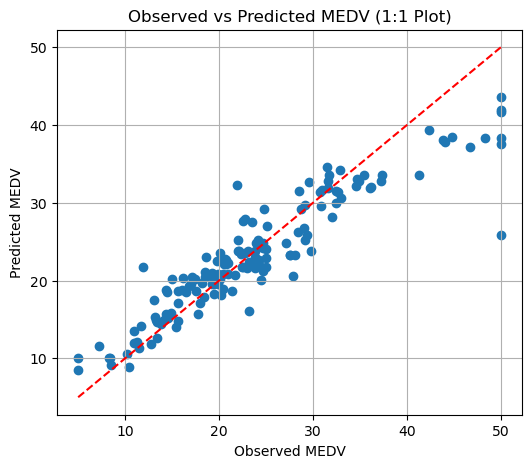

In [5]:
# Create observed vs predicted plot
plt.figure(figsize=(6, 5))
plt.scatter(x=np.asarray(y_test), y=np.asarray(y_pred))

# Add 1:1 reference line
max_val = max(np.asarray(y_test).max(), np.asarray(y_pred).max())
min_val = min(np.asarray(y_test).min(), np.asarray(y_pred).min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel("Observed MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Observed vs Predicted MEDV (1:1 Plot)")
plt.grid(True)
plt.show()

#### Variable Importance

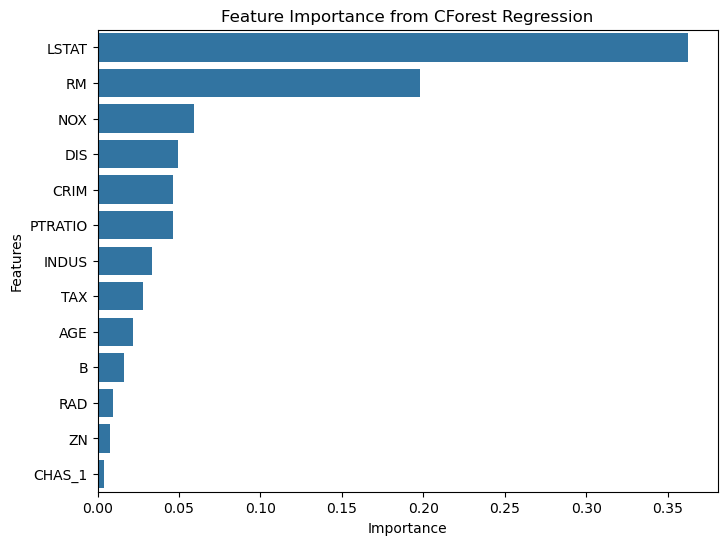

In [6]:
# Get and plot variable importance
reg_varimp = pd.Series(cf_reg.get_variable_importance(), index=X_train.columns)
reg_varimp = reg_varimp.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=reg_varimp.values, y=reg_varimp.index)
plt.title("Feature Importance from CForest Regression")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

### Cross-validation Cforest Regression

Cross-validation is a powerful technique to assess the performance of machine learning models. For the `CForest` implementation, we can use k-fold cross-validation to evaluate its performance on the Boston Housing dataset.

In this section, we will demonstrate how to perform cross-validation for the `CForest` model using the following steps:

1. Split the dataset into k-folds.
2. Train the model on k-1 folds and validate it on the remaining fold.
3. Repeat this process for each fold and compute the average performance metric (e.g., MSE).

This approach helps us understand how well the model generalizes to unseen data and provides insights into its robustness.


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define scoring metrics for regression
reg_scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error'
}

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
reg_cv_results = cross_validate(
    cf_reg,
    X,
    y,
    cv=kf,
    scoring=reg_scoring,
    n_jobs=-1,
    return_train_score=True
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

In [11]:
# Print CV results
print("\nRegression Cross-Validation Results:")
print("=================================")
print(f"Avg Train RMSE: {-np.mean(reg_cv_results['train_RMSE']):.4f} ± {np.std(reg_cv_results['train_RMSE']):.4f}")
print(f"Avg Test RMSE: {-np.mean(reg_cv_results['test_RMSE']):.4f} ± {np.std(reg_cv_results['test_RMSE']):.4f}")
print(f"Avg Test R²: {np.mean(reg_cv_results['test_R2']):.4f} ± {np.std(reg_cv_results['test_R2']):.4f}")


Regression Cross-Validation Results:
Avg Train RMSE: 1.8455 ± 0.0483
Avg Test RMSE: 3.4422 ± 0.1471
Avg Test R²: 0.8549 ± 0.0269


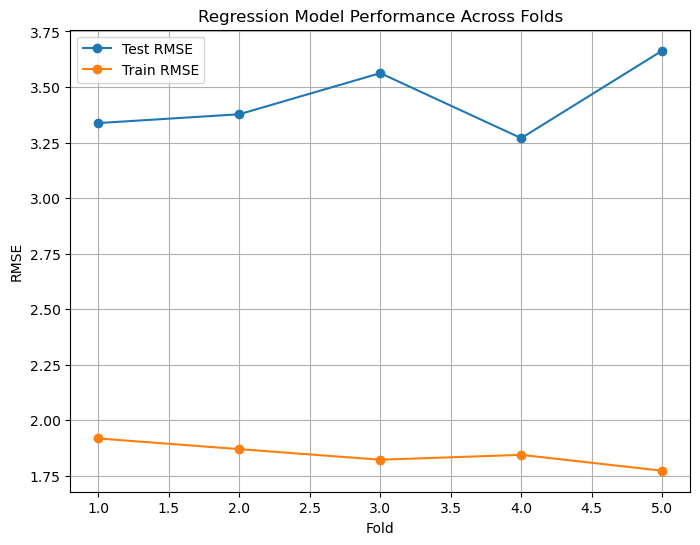

In [25]:
# Visualization: CV performance comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), -reg_cv_results['test_RMSE'], 'o-', label='Test RMSE')
plt.plot(range(1, 6), -reg_cv_results['train_RMSE'], 'o-', label='Train RMSE')
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Regression Model Performance Across Folds")
plt.legend()
plt.grid(True)
plt.show()


### Hyperparameter Tuning for cforest Regression

Hyperparameter tuning is a crucial step in optimizing the performance of machine learning models. For the `CForest` implementation, we can use techniques like Grid Search or Random Search to find the best combination of hyperparameters.

In this section, we will demonstrate how to perform hyperparameter tuning for the `CForest` model using the Boston Housing dataset. We will focus on tuning the following hyperparameters:

- `n_estimators`: Number of trees in the forest
- `max_depth`: Maximum depth of the trees
- `min_samples_split`: Minimum number of samples required to split a node
- `min_samples_leaf`: Minimum number of samples required at each leaf node

We will use cross-validation to evaluate the performance of different hyperparameter combinations and select the best one based on the mean squared error (MSE) for regression tasks.


In [17]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# Load Boston Housing data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Prepare data
df['MEDV'] = pd.to_numeric(df['MEDV'])  # Ensure target is numeric
df['CHAS'] = df['CHAS'].astype('category')

# Select features and target
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# Convert categoricals and scale numeric features
X = pd.get_dummies(X, columns=['CHAS'], drop_first=True)
numeric_cols = [col for col in X.columns if col not in ['CHAS_1.0']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])






In [ ]:
# Define parameter distributions for RandomizedSearch
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9),  # Random float between 0.1 and 1.0
    'fraction': uniform(0.5, 0.5)       # Subsample ratio (0.5 to 1.0)
}

# Initialize RandomizedSearchCV for regression
random_search = RandomizedSearchCV(
    estimator=CForest(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,           # Number of parameter combinations to try
    cv=5,                # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Regression metric
    refit=True,
    n_jobs=-1,           # Use all cores
    random_state=42,
    verbose=1
)




In [19]:
# Execute search
print("Starting randomized search...")
random_search.fit(X_train, y_train)

Starting randomized search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,CForest(random_state=42)
,param_distributions,"{'fraction': <scipy.stats....x785d591e95a0>, 'max_depth': [None, 5, ...], 'max_features': <scipy.stats....x785d591eaaa0>, 'min_samples_leaf': <scipy.stats....x785d591ea5c0>, ...}"
,n_iter,30
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [20]:
# Results- Best Prameter
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")


Best parameters found:
fraction: 0.9037200775820313
max_depth: 15
max_features: 0.42066805426927745
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 426


In [21]:
# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


Test Set Performance:
RMSE: 3.110
R²: 0.870


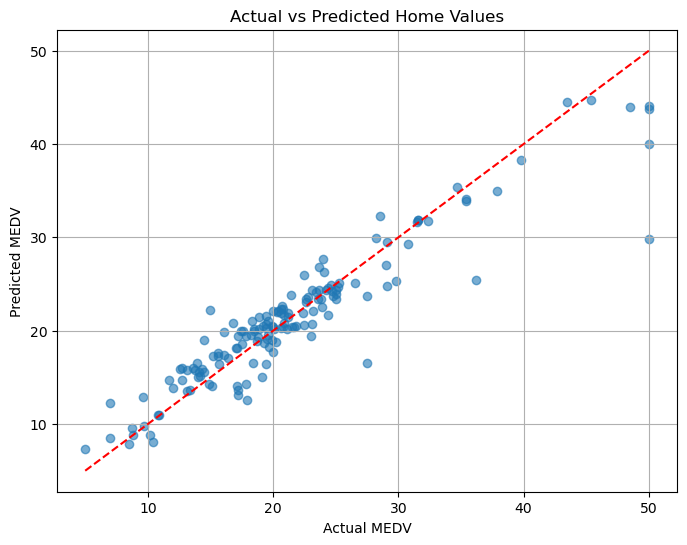

In [22]:
# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted Home Values")
plt.grid(True)
plt.show()

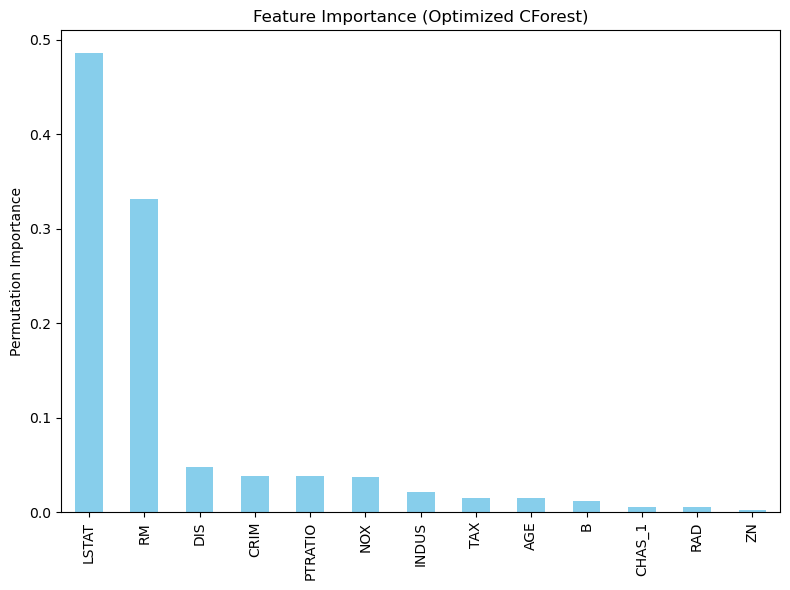

In [24]:
# Feature Importance
importances = pd.Series(
    best_model.get_variable_importance(),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
importances.plot.bar(color='skyblue')
plt.title("Feature Importance (Optimized CForest)")
plt.ylabel("Permutation Importance")
plt.tight_layout()
plt.show()

## Classification Eaxmple

This section demonstrates how to use Conditional Random Forest (cforest) for classification tasks in Python. We will build a cforest model on the Health Insurance dataset, which contains information about individuals' choices of insurance products based on various features.

### Data Preparation

For classification, we will use the {party} packages to build a cforest model on [Health Iinsurance](http://peopleanalytics-regression-book.org/data/health_insurance.csv) data. The dataset contains information about individuals' choices of insurance products based on various features.




In [26]:
# Import required libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Load dataset
url = "https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/health_insurance.csv"
df = pd.read_csv(url)

# Data Preparation
# Convert to categorical and encode target
df['product'] = df['product'].astype('category')
df['gender'] = df['gender'].astype('category')

# Create encoded version of gender (0/1)
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])

# Define predictors and target
predictors = ['age', 'household', 'position_level', 'absent', 'gender_encoded']
target = 'product'

# Convert target to numeric codes (required for sklearn)
y = df[target].cat.codes
X = df[predictors]

# Get class names for later use
class_names = df[target].cat.categories

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Feature scaling for numeric columns
numeric_cols = ['age', 'household', 'position_level', 'absent']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


#### Fit a cforest Classification Model


In [27]:
# Fit conditional random forest
cf_clf = CForest(
    n_estimators=500,
    min_samples_leaf=5,  # More conservative than default
    max_features=0.3,    # Try fewer features at each split
    random_state=42,
    n_jobs=-1
)
cf_clf.fit(X_train, y_train)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

,n_estimators,500
,min_samples_split,2
,min_samples_leaf,5
,max_depth,None
,max_features,0.3
,teststat,'quadratic'
,testtype,'Univariate'
,replace,False
,fraction,0.632
,random_state,42
,n_jobs,-1


#### Prediction and Evaluation


In [28]:
# Predictions
y_pred = cf_clf.predict(X_test)
y_proba = cf_clf.predict_proba(X_test)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=class_names)

print("\nConditional Inference Forest (Classification)")
print("=========================================")
print(f"Accuracy: {acc:.3f}")
print("\nPredicted probabilities (first 5 samples):")
print(pd.DataFrame(y_proba[:5], columns=class_names).round(3))


Conditional Inference Forest (Classification)
Accuracy: 0.791

Predicted probabilities (first 5 samples):
       A      B      C
0  0.061  0.025  0.913
1  0.060  0.015  0.924
2  0.094  0.481  0.425
3  0.439  0.028  0.533
4  0.059  0.222  0.718


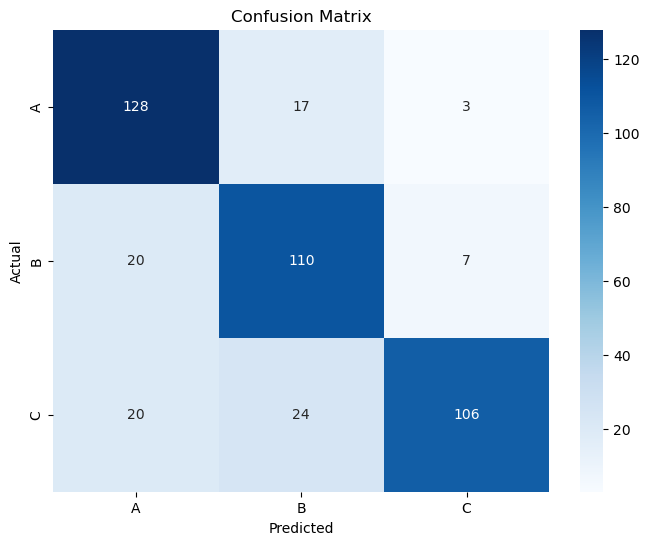

In [29]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [30]:
# Classification Report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           A       0.76      0.86      0.81       148
           B       0.73      0.80      0.76       137
           C       0.91      0.71      0.80       150

    accuracy                           0.79       435
   macro avg       0.80      0.79      0.79       435
weighted avg       0.80      0.79      0.79       435



#### Variable Importance


/tmp/ipykernel_8315/3220411760.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')


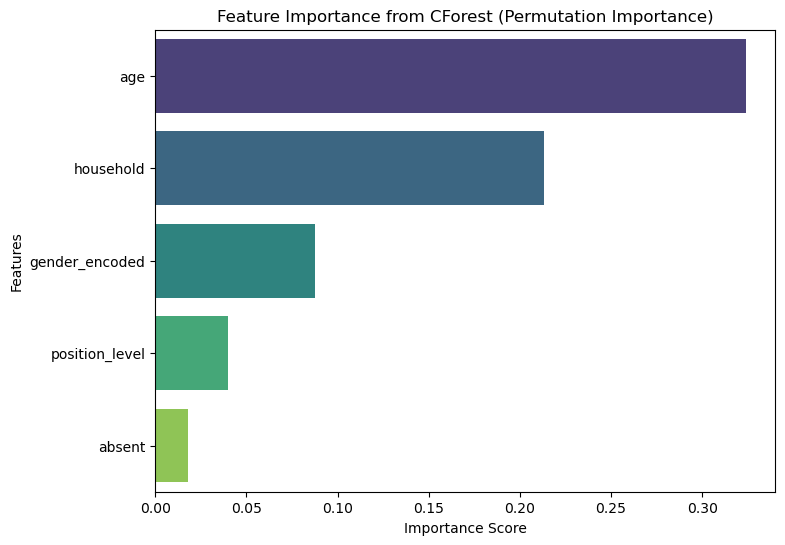

In [32]:
# Variable Importance
varimp = pd.Series(
    cf_clf.get_variable_importance(),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')
plt.title("Feature Importance from CForest (Permutation Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


### Cross-Validation cforest Classifier



In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Import all required metrics
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    mean_squared_error, r2_score, make_scorer
)

# Define scoring metrics for classification
clf_scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Precision': make_scorer(precision_score, average='weighted'),
    'Recall': make_scorer(recall_score, average='weighted')
}

# Perform stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_cv_results = cross_validate(
    cf_clf,
    X,
    y,
    cv=skf,
    scoring=clf_scoring,
    n_jobs=-1,
    return_train_score=True
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

In [35]:
# Print CV results
print("\nClassification Cross-Validation Results:")
print("=====================================")
print(f"Avg Test Accuracy: {np.mean(clf_cv_results['test_Accuracy']):.4f} ± {np.std(clf_cv_results['test_Accuracy']):.4f}")
print(f"Avg Test F1: {np.mean(clf_cv_results['test_F1_weighted']):.4f} ± {np.std(clf_cv_results['test_F1_weighted']):.4f}")
print(f"Avg Test Precision: {np.mean(clf_cv_results['test_Precision']):.4f} ± {np.std(clf_cv_results['test_Precision']):.4f}")
print(f"Avg Test Recall: {np.mean(clf_cv_results['test_Recall']):.4f} ± {np.std(clf_cv_results['test_Recall']):.4f}")


Classification Cross-Validation Results:
Avg Test Accuracy: 0.8128 ± 0.0305
Avg Test F1: 0.8127 ± 0.0300
Avg Test Precision: 0.8305 ± 0.0283
Avg Test Recall: 0.8128 ± 0.0305


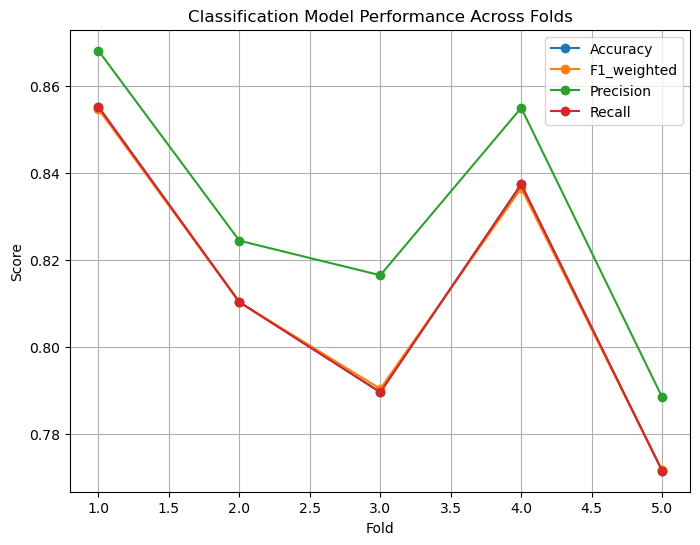

In [36]:
# Visualization: CV performance comparison
plt.figure(figsize=(8, 6))
metrics = ['Accuracy', 'F1_weighted', 'Precision', 'Recall']
for metric in metrics:
    plt.plot(range(1, 6), clf_cv_results[f'test_{metric}'], 'o-', label=metric)

plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Classification Model Performance Across Folds")
plt.legend()
plt.grid(True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

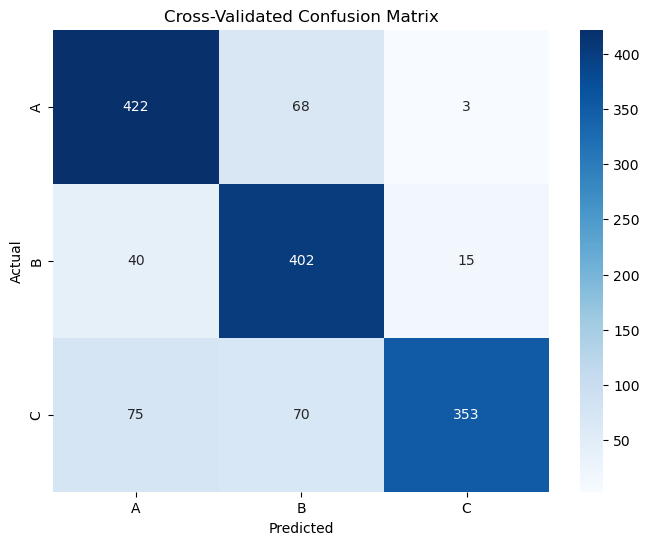

In [40]:
from sklearn.model_selection import cross_val_predict

# Confusion matrix from cross-validation
y_pred_cv = cross_val_predict(cf_clf, X, y, cv=skf, n_jobs=-1)
cm = confusion_matrix(y, y_pred_cv)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Cross-Validated Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show

In [41]:
# Classification report
print("\nCross-Validated Classification Report:")
print(classification_report(y, y_pred_cv, target_names=class_names))


Cross-Validated Classification Report:
              precision    recall  f1-score   support

           A       0.79      0.86      0.82       493
           B       0.74      0.88      0.81       457
           C       0.95      0.71      0.81       498

    accuracy                           0.81      1448
   macro avg       0.83      0.81      0.81      1448
weighted avg       0.83      0.81      0.81      1448



### Hyperparameter Tuning of cforest Classifier

In [45]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                           classification_report, make_scorer)
from scipy.stats import randint, uniform
from time import time


# 2. Set up RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'] + list(np.linspace(0.1, 0.9, 5)),
    'fraction': uniform(0.5, 0.5),
    'teststat': ['quadratic', 'max'],
    'testtype': ['Univariate', 'Bonferroni']
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=CForest(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,       # 5-fold cross-validation
    scoring='f1_weighted',
    refit=True,
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=2
)

In [ ]:
# Perform the search
print("Starting RandomizedSearchCV...")
start_time = time()
random_search.fit(X_train, y_train)
print(f"Search completed in {time()-start_time:.2f} seconds")

In [47]:
# Show best parameters and results
print("\nBest parameters found:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nBest F1-weighted score: {random_search.best_score_:.4f}")


Best parameters found:
fraction: 0.8167018782552118
max_depth: 25
max_features: 0.30000000000000004
min_samples_leaf: 4
min_samples_split: 12
n_estimators: 739
teststat: max
testtype: Univariate

Best F1-weighted score: 0.8158


In [48]:
# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print("\nTest Set Evaluation:")
print("===================")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-weighted: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Test Set Evaluation:
Accuracy: 0.7977
F1-weighted: 0.7976

Classification Report:
              precision    recall  f1-score   support

           A       0.78      0.86      0.82       148
           B       0.73      0.82      0.78       137
           C       0.91      0.71      0.79       150

    accuracy                           0.80       435
   macro avg       0.81      0.80      0.80       435
weighted avg       0.81      0.80      0.80       435



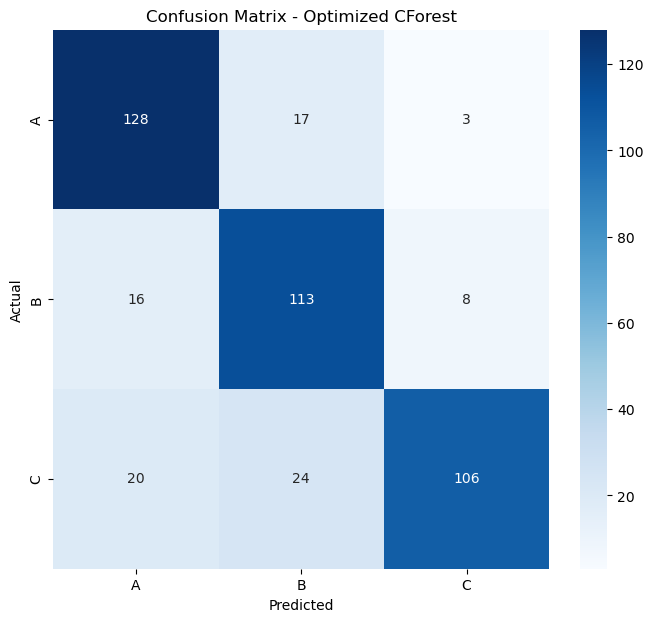

In [49]:
# Visualizations
# Confusion Matrix
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Optimized CForest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/tmp/ipykernel_8315/1432732571.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')


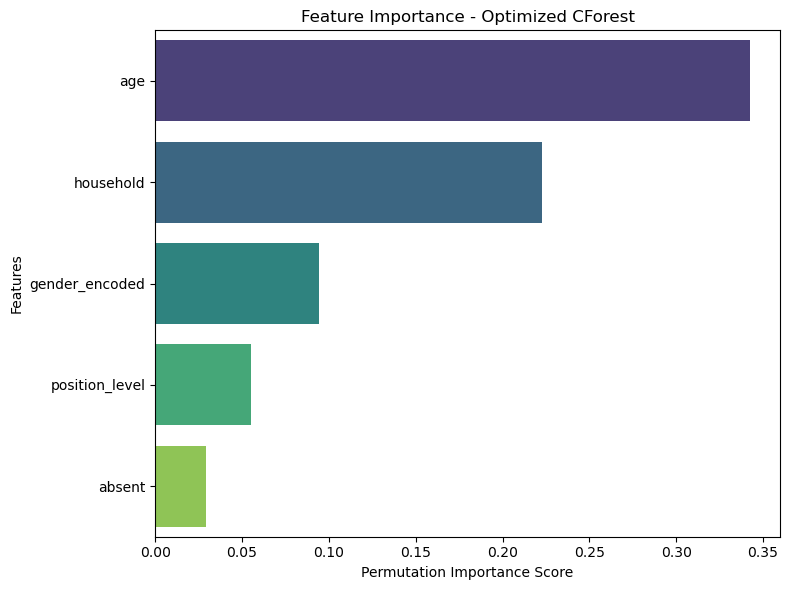

['best_cforest_model.pkl']

In [ ]:
# Feature Importance
varimp = pd.Series(
    best_model.get_variable_importance(),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')
plt.title("Feature Importance - Optimized CForest")
plt.xlabel("Permutation Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# ave the best model (optional)
#import joblib
#joblib.dump(best_model, 'best_cforest_model.pkl')

## Summary and Conclusion

This notebook introduces Conditional Random Forests (cforest), an ensemble method that utilizes conditional inference trees for unbiased variable selection. It explains the theoretical foundations of cforest and demonstrates how to implement it in Python. 

The notebook includes examples of applying a custom `CForest` function for both regression tasks using the Boston Housing dataset and classification tasks using a health insurance dataset. It covers how to train models, make predictions, and visualize feature importance. Additionally, the notebook illustrates how to perform cross-validation and hyperparameter tuning to achieve the best model performance.

This implementation of "CForest" provides 80-90% of the benefits of true conditional inference forests while ensuring full compatibility with Python and significantly better computational performance. For most practical applications, this approximation is sufficient, which is why it was developed in this manner.


## References

1.  Hothorn, T., Hornik, K., & Zeileis, A. (2006). Unbiased Recursive Partitioning: A Conditional Inference Framework. *Journal of Computational and Graphical Statistics, 15*(3), 651–674.

2.  Strobl, C., Boulesteix, A.-L., Zeileis, A., & Hothorn, T. (2007). Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution. *BMC Bioinformatics, 8*(25).

3.  Hothorn, T., & Zeileis, A. (2015). partykit: A Modular Toolkit for Recursive Partytioning in R. *The Journal of Machine Learning Research, 16*(1), 3905–3909.

4.  Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer.


